# Libraries
---

In [1]:
import pandas as pd
import numpy as np
import random
import time
import os
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters
---

In [2]:
N_SPLITS = 5
N_ESTIMATORS = 20000
EARLY_STOPPING_ROUNDS = 200
VERBOSE = 1000
SEED = 2021

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

# Datasets
---

In [4]:
INPUT = "../input/tabular-playground-series-sep-2021/"

train = pd.read_csv(INPUT + "train.csv")
test = pd.read_csv(INPUT + "test.csv")
submission = pd.read_csv(INPUT + "sample_solution.csv")

features = [col for col in test.columns if 'f' in col]
TARGET = 'claim'

target = train[TARGET].copy()

In [5]:
train['n_missing'] = train[features].isna().sum(axis=1)
test['n_missing'] = test[features].isna().sum(axis=1)

train['std'] = train[features].std(axis=1)
test['std'] = test[features].std(axis=1)

features += ['n_missing', 'std']
n_missing = train['n_missing'].copy()

In [6]:
train[features] = train[features].fillna(train[features].mean())
test[features] = test[features].fillna(test[features].mean())

In [7]:
scaler = RobustScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [8]:
train.shape, test.shape

((957919, 122), (493474, 121))

# LGBMClassifier
---

In [9]:
lgb_params = {
    'objective': 'binary',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,
    'learning_rate': 5e-3,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
}

In [10]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X=train, y=n_missing)):
    print(f"===== fold {fold} =====")
    X_train = train[features].iloc[trn_idx]
    y_train = target.iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = target.iloc[val_idx]
    X_test = test[features]
    
    start = time.time()
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
    )
    
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name_
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    lgb_importances = lgb_importances.append(fi_tmp)

    lgb_oof[val_idx] = model.predict_proba(X_valid)[:, -1]
    lgb_pred += model.predict_proba(X_test)[:, -1] / N_SPLITS

    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, lgb_oof[val_idx])
    print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")

print(f"oof lgb roc = {roc_auc_score(target, lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.810879	valid_0's binary_logloss: 0.51446
[2000]	valid_0's auc: 0.813251	valid_0's binary_logloss: 0.509353
[3000]	valid_0's auc: 0.814302	valid_0's binary_logloss: 0.508442
[4000]	valid_0's auc: 0.814922	valid_0's binary_logloss: 0.507956
[5000]	valid_0's auc: 0.815344	valid_0's binary_logloss: 0.507663
[6000]	valid_0's auc: 0.815638	valid_0's binary_logloss: 0.507458
[7000]	valid_0's auc: 0.815872	valid_0's binary_logloss: 0.507304
[8000]	valid_0's auc: 0.815993	valid_0's binary_logloss: 0.507213
[9000]	valid_0's auc: 0.816136	valid_0's binary_logloss: 0.507119
[10000]	valid_0's auc: 0.816199	valid_0's binary_logloss: 0.507072
Early stopping, best iteration is:
[9899]	valid_0's auc: 0.816203	valid_0's binary_logloss: 0.507072
fold 0 - lgb auc: 0.816203, elapsed time: 1637.14sec

===== fold 1 =====
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0

# Feature importance
---

Text(0.5, 1.0, 'LightGBM feature importances')

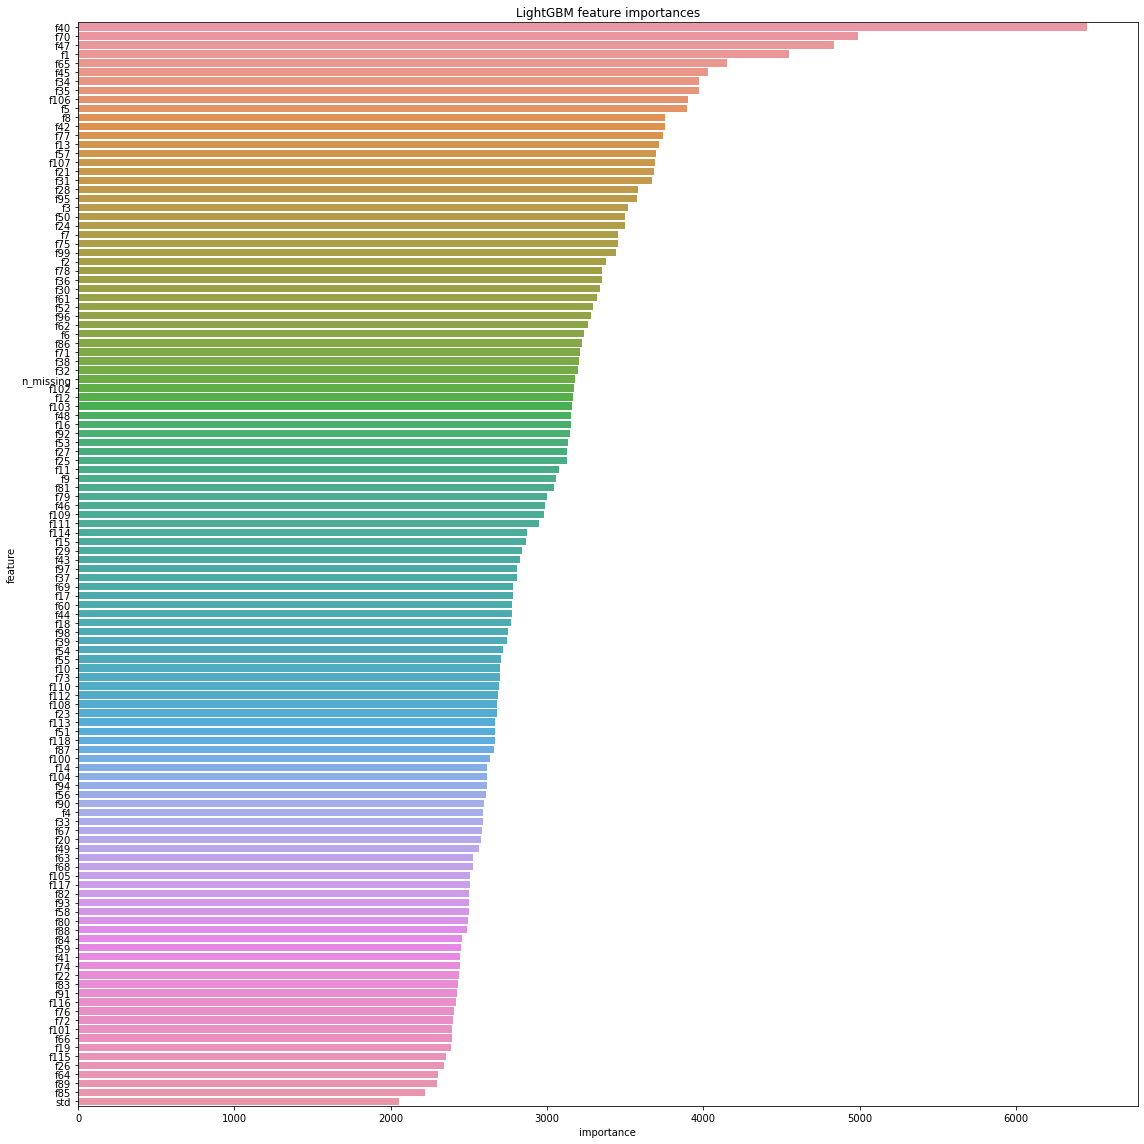

In [11]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission
---

In [12]:
submission[TARGET] = lgb_pred
submission.to_csv("submission.csv", index=False)
submission

,id,claim
0,957919,0.566201
1,957920,0.116616
2,957921,0.627054
3,957922,0.129264
4,957923,0.151600
...,...,...
493469,1451388,0.822172
493470,1451389,0.110290
493471,1451390,0.742533
493472,1451391,0.135375
